In [1]:
library(benchmarkme)
get_platform_info()$OS.type
get_r_version()$version.string
get_cpu()$model_name;get_cpu()$no_of_cores
get_ram()

[1] "windows"

[1] "R version 3.5.1 (2018-07-02)"

[1] "Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz"

[1] 8

8.59 GB

In [2]:
# Loading data
geno <-read.table("./Hetero_realigned_cov10_filtered3.raw", 
                  row.names=1, header=T)
row.names(geno)=1:240

## Number of SNPs for each chromosome

In [3]:
# Position data
lin_map<-read.table("raw.map")
m<-1:22; chr<-1:22
for(i in chr) {m[i]=dim(lin_map[lin_map$V1==i,])[1]}

## Simulator

In [4]:
# Modified xbreed
# library("devtools")
# install_github("gglinzijie/xbreed",force=TRUE)
library("xbreed")

("|-----------------------------------------------------|")
("|                      xbreed                         |")
("|    Genomic simulation of purebreds and crossbreds   |")
("|               March 2017 Version 1.0.1              |")
("|                                                     |")
("|             H.Esfandyari,A.C.Sorensen               |")
("| Center for Quantitative Qenetics and Genomics (QGG) |")
("|             Aarhus University,Denmark               |")
("|                                                     |")
("|-----------------------------------------------------|")
("|Questions and bugs: esfandyari.hadi@gmail.com        |")
("|Development of xbreed was supported by GenSAP.       |")
("|-----------------------------------------------------|")


## Genome specification

In [5]:
#parameter of genome
genome<-data.frame(matrix(NA, nrow=22, ncol=6))
names(genome)<-c("chr","len","nmrk","mpos","nqtl","qpos")
genome$chr<-c(1:22) # Chromosome id from 1 to 22
genome$len<-c(200,rep(100,21))# Chromosome length in cM
genome$nmrk<-c(m) # Number of markers per chr, 3928 in total 
genome$mpos<-c('even') # Markers are evenly spaced
genome$nqtl<-c(40) # Number of qtl  40*22 = 880 in total
genome$qpos<-c('rnd') # Position of QTL are random.

## Build the historical (wild) population

In [6]:
#Historical population 
hp<-make_hp(hpsize=1000 ,ng=5000,h2=0.654,d2=0,phen_var=84,
            genome=genome,mutr=2.5*10**-4,laf=1)

---sel_seq_qtl is missing, it has been set to default value of 0
---sel_seq_mrk is missing, it has been set to default value of 0
Historical pop is initialized...
Simulating trait ...
Output data preparation ...
Establishment of historical population completed


In [7]:
# Expected Heterozygosity according to (Kimura and Crow 1964) 
mutr<-2.5*10**-4
ne<-1000 
k<-2 
Fneu<-4*ne*mutr 
(Expected_het1<-Fneu/(1+Fneu))
(Expected_het2<-1-((1+((Fneu)/(k-1)))/(1+((Fneu*k)/(k-1)))))
(het_observed<-mean(2*(hp$freqMrk[,3]*hp$freqMrk[,4])))

[1] 0.5

[1] 0.3333333

[1] 0.3997211

## General specification

In [8]:
Male_founders<-data.frame(number=10,select='rnd')
Female_founders<-data.frame(number=10,select='rnd')

In [9]:
Selection<-data.frame(matrix(NA, nrow=2, ncol=3))
names(Selection)<-c('Number','type','Value') 
Selection$Number[1:2]<-c(10,10)
Selection$type[1:2]<-c('gebv','gebv')
Selection$Value[1:2]<-c('l','l')

In [10]:
# Training parameters for the estimation of marker effects. 
Training<-data.frame(matrix(NA, nrow=1, ncol=8))
names(Training)<-c('size','sel','method','nIter','burnIn','thin','save','show')
Training$size<-250
Training$sel<-'rnd'
Training$method<-'BayesC'
Training$nIter<-2000
Training$burnIn<-1000 
Training$thin<-5 
Training$save<-'bayes'
Training$show<-FALSE

In [11]:
sh_output<-data.frame(matrix(NA, nrow=11, ncol=1))
names(sh_output)<-c("data")
sh_output[,1]<-c(seq(0,10,1))

In [12]:
# Function for calculating the allele coding, which is 0, 1, 2
bin_snp<-function(mat){
s1<-seq(1,ncol(mat),2)
s2<-seq(2,ncol(mat),2)
a1<-mat[,s1]+mat[,s2]
a1[a1==3]=1
a1[a1==4]=0
snp_code<-a1
return(snp_code)
 }

In [13]:
# Function of simulating scenarios with different selection intensity
selectionIntensity<-function(u,litter_size){
Selection$Number[1:2]<-c(u,u)
#20 sires and 20 dams perform complete cross; 200 eggs were produced per dam.
RP<-sample_hp(hp_out=hp,Male_founders= Male_founders,
              Female_founders=Female_founders,ng=10,Selection=Selection,
              Training=Training,
              litter_size=litter_size,saveAt="SNP3928_20",sh_output=sh_output,Display=FALSE)
hete<-list()
gain<-list()
gain[1]<-0
for (i in seq(1,10,1)){
n<-bin_snp(RP$output[[i+1]]$mrk[,3:7858])
hete[i]<-sum(n==1)/(dim(n)[1]*dim(n)[2])
}
for (i in seq(1,9,1)){
gain[i+1]<-abs(RP$summary_data$TrueBV[i+1]-RP$summary_data$TrueBV[1])
}
cbind(RP$summary_data,unlist(hete),unlist(gain))
    }

## Scenarios with different selection intensity

In [ ]:
summary5<-selectionIntensity(5,30)

In [ ]:
summary10<-selectionIntensity(10,8)

In [ ]:
summary15<-selectionIntensity(15,4)

In [ ]:
summary20<-selectionIntensity(20,4)

Controlling input data ...
Intializing base population ...
Generation 0 started .......

In [38]:
library("xlsx")
write.xlsx(summary5, "summary5.xlsx") 
write.xlsx(summary10, "summary10.xlsx") 
write.xlsx(summary15, "summary15.xlsx") 
write.xlsx(summary20, "summary20.xlsx") 

## Plot

In [70]:
# Data frame for plot
plot<-data.frame(SelectionResponse=as.numeric(c(summary5[,9],
                                             summary10[,9],
                                             summary15[,9],
                                             summary20[,9])),
                 heritability=as.numeric(c(summary5$heritability,
                                             summary10$heritability,
                                             summary15$heritability,
                                             summary20$heritability)),
                 heterozygosity=as.numeric(c(summary5[,8],
                                             summary10[,8],
                                             summary15[,8],
                                             summary20[,8])),
                 ng=as.factor(rep(seq(1,10,1),4)),
                 intensity=as.factor(rep(c(5,10,15,20),each = 10)))

In [73]:
write.xlsx(plot, "plot25.xlsx") 
library("readxl")
plot<-read_excel("plot25.xlsx")

In [51]:
plot$intensity<-factor(plot$intensity,levels = c(5,10,15,20))
plot$ng<-factor(plot$ng,levels = c(seq(1,10,1)))

In [52]:
plot

X__1,SelectionResponse,heritability,heterozygosity,ng,intensity
1,0.000000,0.6617558,0.4023461,1,5
2,17.738264,0.5307376,0.3008282,2,5
3,25.271771,0.4876681,0.2391673,3,5
4,33.340748,0.3491821,0.2207712,4,5
5,40.980753,0.3661178,0.1975927,5,5
6,47.814221,0.2667079,0.1678265,6,5
7,52.157453,0.2260765,0.1487957,7,5
8,55.987811,0.1791554,0.1334742,8,5
9,58.763893,0.1245893,0.1268598,9,5
10,60.652799,0.1427275,0.1140353,10,5


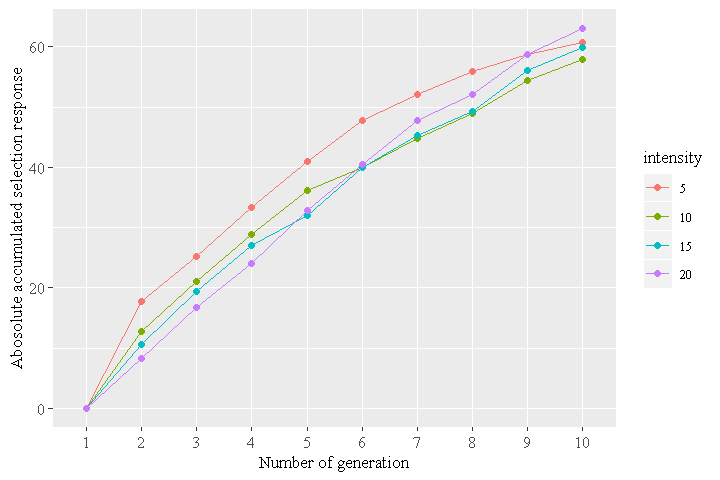

In [53]:
library(ggplot2)
options(repr.plot.width=6, repr.plot.height=4)
p1 <- ggplot(plot, aes(x=ng, y=SelectionResponse,group=intensity)) + 
       geom_line(aes(color=intensity))+
       geom_point(aes(color=intensity))+    
       labs(x = "Number of generation",y="Abosolute accumulated selection response")+
       theme(axis.text.y= element_text(size = rel(1.2)),
             axis.text.x = element_text(size = rel(1.2)),
                  text=element_text(size=10, family="serif"))
p1

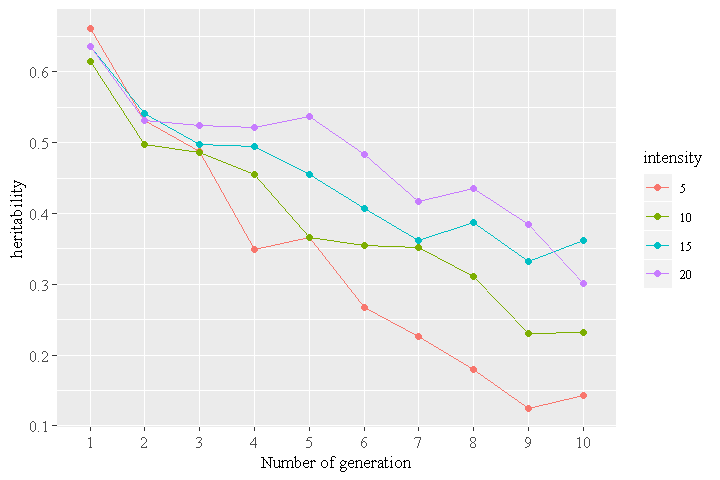

In [45]:
p2 <- ggplot(plot, aes(x=ng, y=heritability,group=intensity)) + 
       geom_line(aes(color=intensity))+
       geom_point(aes(color=intensity))+    
       labs(x = "Number of generation",y="heritability")+
       theme(axis.text.y= element_text(size = rel(1.2)),
             axis.text.x = element_text(size = rel(1.2)),
                  text=element_text(size=10, family="serif"))
p2

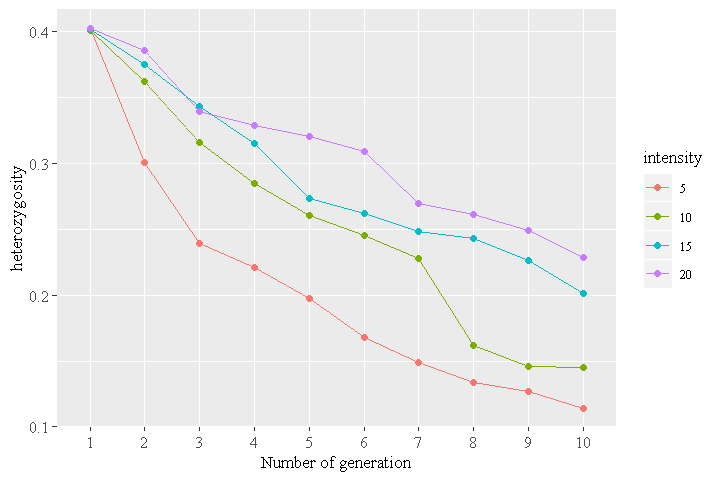

In [48]:
p3 <- ggplot(plot, aes(x=ng, y=heterozygosity,group=intensity)) + 
       geom_line(aes(color=intensity))+
       geom_point(aes(color=intensity))+    
       labs(x = "Number of generation",y="heterozygosity")+
       theme(axis.text.y= element_text(size = rel(1.2)),
             axis.text.x = element_text(size = rel(1.2)),
                  text=element_text(size=10, family="serif"))
p3

In [54]:
png("2_5 accumulated selection response.png", width=6, height=4, units="in", res=300)
p1
dev.off()
png("2_5 heritability.png", width=6, height=4, units="in", res=300)
p2
dev.off()
png("2_5 heterozygosity.png", width=6, height=4, units="in", res=300)
p3
dev.off()

png 
  2

png 
  2

png 
  2